In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import *
from motion_models import MM_CTRV
from simulation import *
from scenarios import get_scenario
from filters import EKF_CTRV, UKF_CTRV
from scipy.stats import circmean

In [2]:
def filter_cyclic(frame, kf_f, meas):
    if frame == 0:
        kf_f.x = np.zeros(kf_f.dim_state)
        z0 = np.array([meas[0] * np.cos(meas[1]), meas[0] * np.sin(meas[1])])
        kf_f.x[IX], kf_f.x[IY] = z0[0], z0[1]
        kf_f.P = np.diag([3**2, 3**2, np.radians(90)**2, 20**2, np.radians(10)**2])
    else:
        kf_f.predict()
        kf_f.update(meas)

In [3]:
# FILTER EVALUATION SINGLE SCENARIO

# experiment parameters
T = 0.05
sc_id = '5'
SEED = 1
n_iter = 10
std_r = 0.5
std_phi = np.radians(2)
var_v = 5**2
var_w = np.radians(10)**2
sim_var_v, sim_var_w = 2**2, 0
kf_vec = [
    {'label': 'EKF', 'filter': EKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#DE3163'},
    {'label': 'UKF', 'filter': UKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#32cd32'},
    # {'label': 'UKF low varw', 'filter': UKF_CTRV(T, var_v, np.radians(15)**2, std_r, std_phi), 'color': '#000080'},
]

np.random.seed(SEED)

# generating ground truth
sc = get_scenario(sc_id, T)
n_frames = int(sc['n_frames'])
m_ctrv = MM_CTRV(sim_var_v, sim_var_w)
sim_state = simulate_motion_CTRV(T, n_frames, sc['x_init'], m_ctrv, sc['accw_frames'])

frame_vec = np.arange(n_frames)
n_filters = len(kf_vec)
X = np.zeros((5, n_frames, n_filters, n_iter)) # to store average state estimation
Err = np.zeros((5, n_frames, n_filters, n_iter)) # to store track estimate errors
Err_meas = np.zeros((n_frames, n_iter)) # to store meas error

for iter_ in range(n_iter):
    # generate measurements
    meas_pol = simulate_measurements_polar(sim_state, std_r, std_phi, 0.1)

    X_iter = np.zeros((5, n_frames, n_filters))
    Err_iter = np.zeros((5, n_frames, n_filters))

    Err_meas[:, iter_] = (meas_pol[IMX, :] - sim_state[IX, :])**2 + (meas_pol[IMY, :] - sim_state[IY, :])**2

    for i, kf in enumerate(kf_vec):
        kf_f = kf['filter']
        for frame in frame_vec:
            meas = np.array([meas_pol[IMR, frame], meas_pol[IMPHI, frame]])
            filter_cyclic(frame, kf_f, meas)
            X_iter[:, frame, i] = kf_f.x
            Err_iter[:, frame, i] = kf_f.x - sim_state[:, frame]
            
    X[:, :, :, iter_] = X_iter
    Err_iter[IPHI, :, :] = wrap_angle2(Err_iter[IPHI, :, :])
    Err[:, :, :, iter_] = Err_iter

# getting metrics
Xm = np.mean(X, axis=3)
Xm[IPHI, :, :] = circmean(X[IPHI, :, :, :], axis=2, low=-np.pi, high=np.pi)
rmse_meas = np.sqrt(np.mean(Err_meas, axis=1))
rmse_pos = np.sqrt(np.mean(Err[IX, :, :, :]**2 + Err[IY, :, :, :]**2, axis=2))
rmse_phi = np.degrees(np.sqrt(circmean(Err[IPHI, :, :, :]**2, axis=2)))
rmse_vel = np.sqrt(np.mean(Err[IV, :, :, :]**2, axis=2))
rmse_omg = np.degrees(np.sqrt(np.mean(Err[IW, :, :, :]**2, axis=2)))

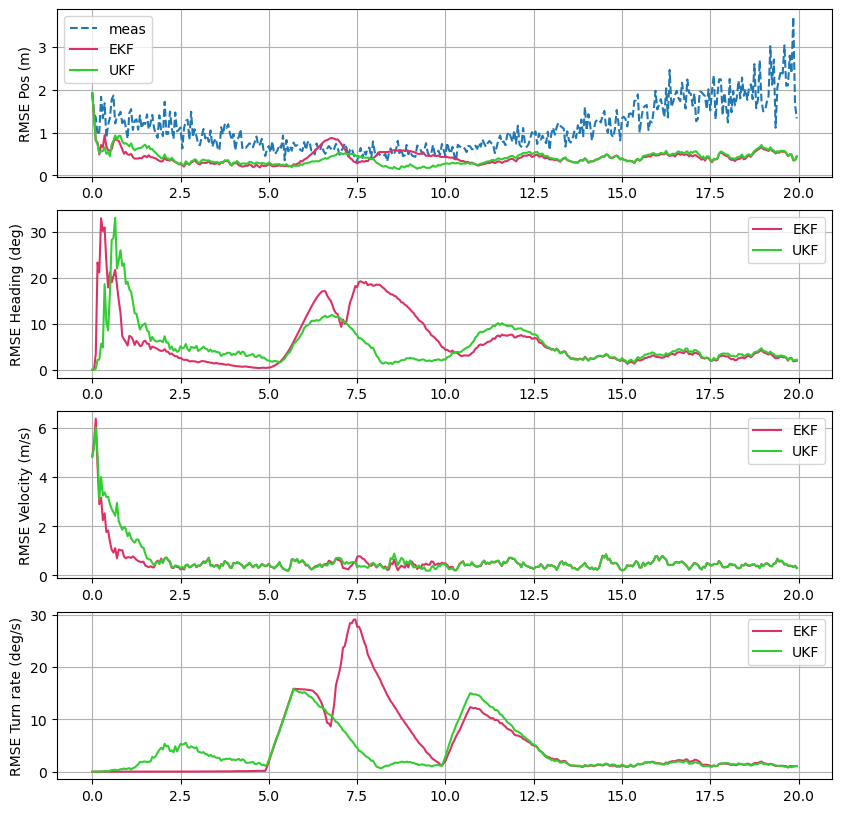

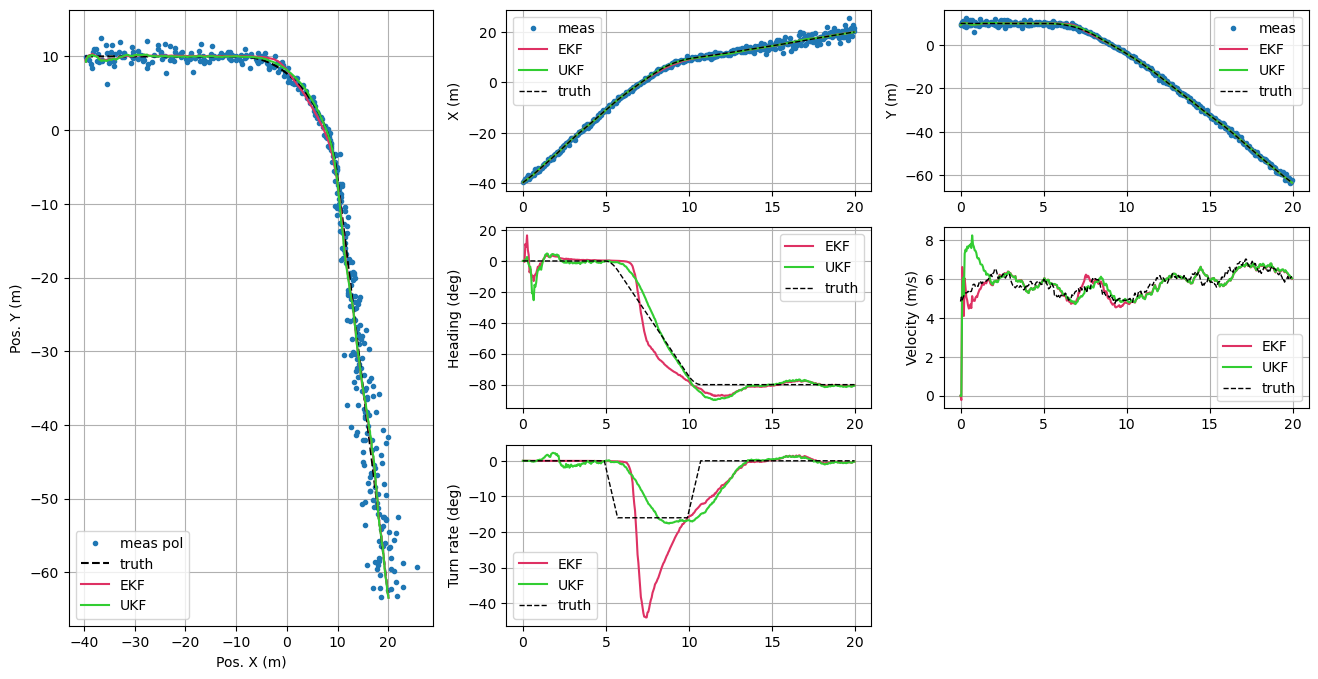

In [4]:
plot_options = [
    {'ylabel': 'RMSE Pos (m)', 'data': rmse_pos, 'plot_meas': True},
    {'ylabel': 'RMSE Heading (deg)', 'data': rmse_phi},
    {'ylabel': 'RMSE Velocity (m/s)', 'data': rmse_vel},
    {'ylabel': 'RMSE Turn rate (deg/s)', 'data': rmse_omg},
]
time_vec = frame_vec*T
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(4, 1)
for i, p in enumerate(plot_options):
    ax1 = fig.add_subplot(gs[i, 0])
    if p.get('plot_meas', False):
        ax1.plot(time_vec, rmse_meas, '--', label='meas')
    for i, kf in enumerate(kf_vec):
        ax1.plot(time_vec, p['data'][:, i], '-', label=kf['label'], color=kf['color'])
    ax1.set_ylabel(p['ylabel'])
    ax1.legend()
    ax1.grid()

# visualization
Xm[IPHI, :, :] = np.degrees(Xm[IPHI, :, :])
Xm[IW, :, :] = np.degrees(Xm[IW, :, :])
plot_options = [
    {'grid_pos': (0, 1), 'index': IX, 'ylabel': 'X (m)', 'meas_index': IMX},
    {'grid_pos': (0, 2), 'index': IY, 'ylabel': 'Y (m)', 'meas_index': IMY},
    {'grid_pos': (1, 1), 'index': IPHI, 'ylabel': 'Heading (deg)', 'fn': np.degrees},
    {'grid_pos': (1, 2), 'index': IV, 'ylabel': 'Velocity (m/s)'},
    {'grid_pos': (2, 1), 'index': IW, 'ylabel': 'Turn rate (deg)', 'fn': np.degrees},
]
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(meas_pol[IMX, :], meas_pol[IMY], '.', label='meas pol')
ax1.plot(sim_state[IX, :], sim_state[IY, :], 'k--', label='truth')
for i, kf in enumerate(kf_vec):
    ax1.plot(Xm[IX, :, i], Xm[IY, :, i], '-', label=kf['label'], color=kf['color'])
ax1.legend()
ax1.grid()
ax1.set_xlabel('Pos. X (m)')
ax1.set_ylabel('Pos. Y (m)')
for p in plot_options:
    ax = fig.add_subplot(gs[*p['grid_pos']])
    sim_var = sim_state[p['index']]
    if p.get('meas_index', False):
        ax.plot(time_vec, meas_pol[p['meas_index'], :], '.', label='meas')
    if p.get('fn', False):
        sim_var = p['fn'](sim_var)
    for i, kf in enumerate(kf_vec):
        ax.plot(time_vec, Xm[p['index'], :, i], '-', label=kf['label'], color=kf['color'])
    ax.plot(time_vec, sim_var, 'k--', label='truth', linewidth=1)
    ax.set_ylabel(p['ylabel'])
    ax.legend()
    ax.grid()

In [5]:
# How robust are they to mismatches in process noise?

np.random.seed(SEED)
KF = UKF_CTRV
n_iter = 10
varv_vec = np.array([1, 3, 5, 10])**2
varw_vec = np.radians([5, 10, 15, 30, 50])**2

n_varv = len(varv_vec)
n_varw = len(varw_vec)
Err = np.zeros((5, n_varv, n_varw, n_frames, n_iter))

exp_count = 1
for iter_ in range(n_iter):
    print(f'iter {iter_+1}/{n_iter}')
    meas_pol = simulate_measurements_polar(sim_state, std_r, std_phi, 0.1)
    for i, var_v in enumerate(varv_vec):
        for j, var_w in enumerate(varw_vec):
            kf = KF(T, var_v, var_w, std_r, std_phi)

            Err_iter = np.zeros((5, n_frames))
            
            for frame in frame_vec:
                meas = np.array([meas_pol[IMR, frame], meas_pol[IMPHI, frame]])
                filter_cyclic(frame, kf, meas)
                Err_iter[:, frame] = kf.x - sim_state[:, frame]
                    
            Err_iter[IPHI, :] = wrap_angle2(Err_iter[IPHI, :])
            Err[:, i, j, :, iter_] = Err_iter
        exp_count += 1

# computing RMSE
Err = np.reshape(Err, newshape=(5, n_varv, n_varw, -1))
rmse_pos = np.sqrt(np.mean(Err[IX]**2 + Err[IY]**2, axis=-1))
rmse_vel = np.sqrt(np.mean(Err[IV]**2, axis=-1))
rmse_phi = np.degrees(np.sqrt(circmean(Err[IPHI]**2, axis=-1)))
rmse_w = np.degrees(np.sqrt(np.mean(Err[IW]**2, axis=-1)))

# saving resutls from experiment
data = {
    'varvs': varv_vec,
    'varws': varw_vec,
    'rmse_pos': rmse_pos,
    'rmse_phi': rmse_phi,
    'rmse_vel': rmse_vel,
    'rmse_w': rmse_w,
}
np.savez(f"{KF.__name__}_evaluation", **data)

iter 1/10
iter 2/10
iter 3/10
iter 4/10


KeyboardInterrupt: 

C:\Users\truji\AppData\Local\Temp\ipykernel_25000\12485267.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.82, 1))
C:\Users\truji\AppData\Local\Temp\ipykernel_25000\12485267.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.82, 1))
C:\Users\truji\AppData\Local\Temp\ipykernel_25000\12485267.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.82, 1))


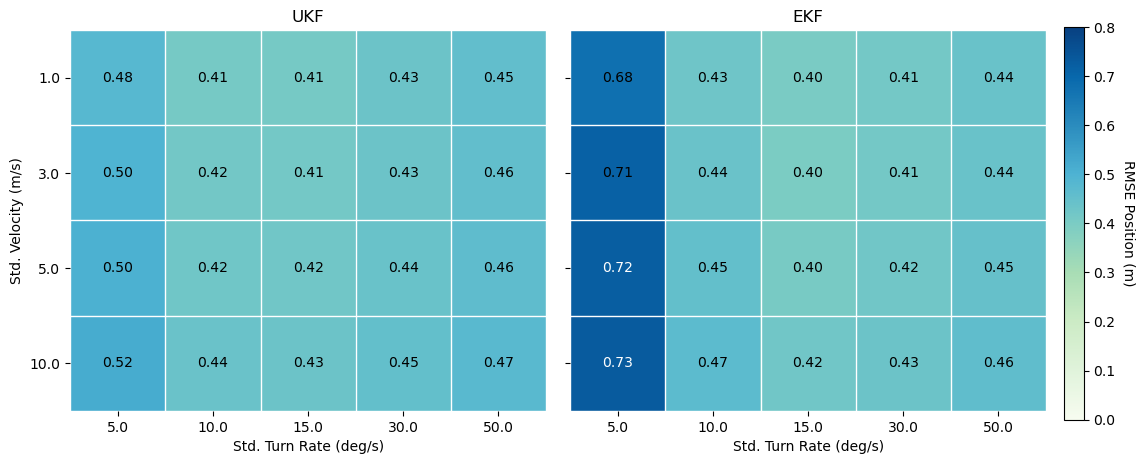

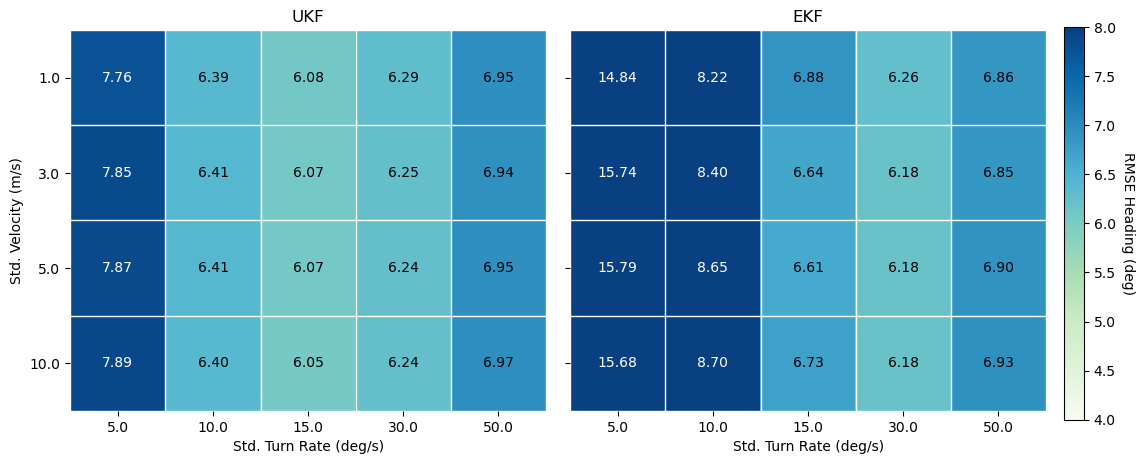

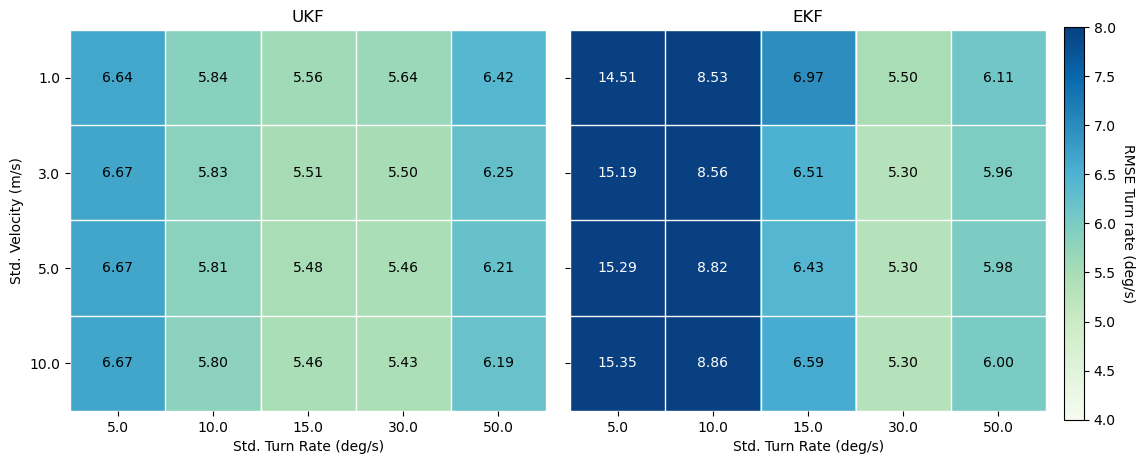

In [1]:
from utils import *

data_ukf = np.load('UKF_CTRV_evaluation.npz')
data_ekf = np.load('EKF_CTRV_evaluation.npz')

stdvs = np.round(np.sqrt(data_ukf['varvs']), 2)
stdws = np.round(np.degrees(np.sqrt(data_ukf['varws'])), 2)

plot_options = [
    {'data_label': 'rmse_pos', 'cbar_label': "RMSE Position (m)", 'limits': (0, 0.8)},
    # {'data_label': 'rmse_vel', 'cbar_label': "RMSE Veloctiy (m/s)", 'limits': (0.5, 2)},
    {'data_label': 'rmse_phi', 'cbar_label': "RMSE Heading (deg)", 'limits': (4, 8)},
    {'data_label': 'rmse_w', 'cbar_label': "RMSE Turn rate (deg/s)", 'limits': (4, 8)}
]
exp_options = [
    {'name': 'UKF', 'data': data_ukf},
    {'name': 'EKF', 'data': data_ekf},
]

for p in plot_options:
    fig, axes = plt.subplots(figsize=(13, 6), ncols=2, sharey=True)
    label = p['data_label']
    vmin, vmax = p['limits'][0], p['limits'][1]
    thr = 0.9*(vmax-vmin) + vmin
    for i, exp in enumerate(exp_options):
        # ax = fig.add_subplot(gs[0, i])
        ax = axes[i]
        ax.set_title(exp['name'])
        im = heatmap(exp['data'][label], stdvs, stdws, ax=ax,
                        cmap="GnBu", cbarlabel=p['cbar_label'], vmin=vmin, vmax=vmax)
        texts = annotate_heatmap(im, valfmt="{x:.2f}", threshold=thr)
        if i == 0:
            ax.set_ylabel('Std. Velocity (m/s)')
        ax.set_xlabel('Std. Turn Rate (deg/s)')
    cbar = fig.colorbar(im, ax=axes, fraction=.1, pad=0, shrink=0.85)
    cbar.ax.set_ylabel(p['cbar_label'], rotation=-90, va="bottom")
    fig.tight_layout(rect=(0, 0, 0.82, 1))
plt.show()